## Homework 04

SOLVED by ANGELA CARRARO

### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

**Solution.**

a. The HMC algorithm is:

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [2]:
def model(x):
    with pyro.plate('theta'):
        theta1 = pyro.sample("theta1", dist.Exponential(5.))
        theta2 = pyro.sample("theta2", dist.Normal(5., 7.))
    y = pyro.param("y", (theta1 * x)/(theta2 + x))
    return y

In [3]:
# measurement observations
xobs = torch.tensor([28, 55, 110, 138, 225, 375])
yobs = torch.tensor([0.053, 0.060, 0.112, 0.105, 0.099, 0.122])

conditioned_model = pyro.condition(model, data={"y": yobs})
conditioned_model(xobs)

hmc_kernel = HMC(model=conditioned_model) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=1000, num_chains=3)

# posteriors 
posterior = mcmc.run(xobs)

# dictionary of sampled values
print(mcmc.get_samples().keys())
mcmc.summary()




dict_keys(['theta1', 'theta2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.24      0.23      0.15      0.01      0.57    114.88      1.03
    theta2      6.01      8.05      5.37     -6.11     18.75     19.84      1.13

Number of divergences: 0


b. Different parameters for both priors and the HMC algorithm lead to different estimates, in fact if we change the parameters in the priors distribution we will get different values for $\theta_1$ and $\theta_2$. This is because the posterior probability is an update of our prior information contained in the prior probability, it is build over the prior, so if we change the latter also the former will change, and so will change the estimates of the parameters. Since we use the prior to compute the posterior, if we use very different priors the posteriors will be very different among them, so it is not possible a convergence towards common values for the estimates.

c. The plot of the most reliable posterior distributions, according to convergence checks on the traces, is:

torch.Size([3, 500])


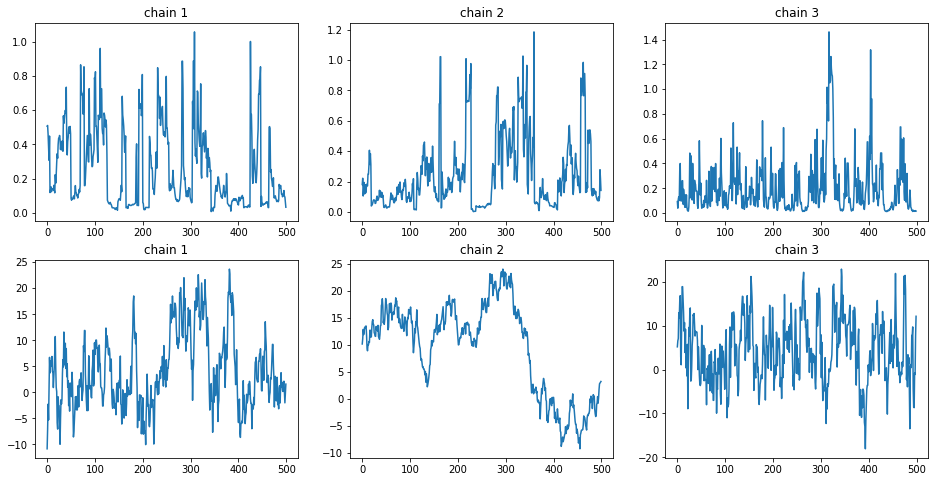

In [4]:
# extracting weight samples and grouping them by chains
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains1 = mcmc_samples["theta1"]
chains2 = mcmc_samples["theta2"]

n_chains, n_samples = chains1.shape
print(chains1.shape)

fig, ax = plt.subplots(2, n_chains, figsize=(16,8))
for i, chain in enumerate(chains1):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[0, i])
    ax[0, i].set_title("chain "+str(i+1))
for i, chain in enumerate(chains2):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[1, i])
    ax[1, i].set_title("chain "+str(i+1))

expected theta1 = 0.23622889816761017
expected theta2 = 6.012410640716553


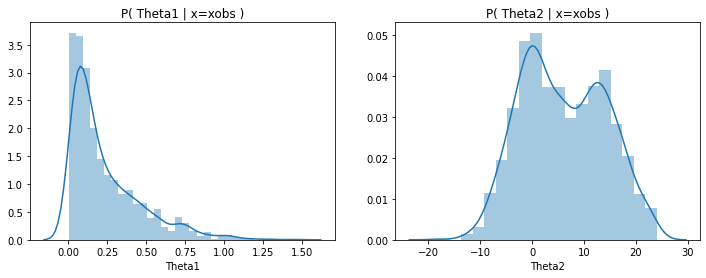

In [5]:
print("expected theta1 =", mcmc_samples['theta1'].mean().item())
print("expected theta2 =", mcmc_samples['theta2'].mean().item())

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(mcmc_samples['theta1'], ax=axes[0])
sns.distplot(mcmc_samples['theta2'], ax=axes[1])
axes[0].set_title("P( Theta1 | x=xobs )")
axes[0].set_xlabel("Theta1")
axes[1].set_title("P( Theta2 | x=xobs )")
axes[1].set_xlabel("Theta2")
plt.show()

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

**Solution.**



a. Given that the conditional expectation of $x_1$ given $x_2$ is $p(x_1 \mid x_2) \sim \mathcal{N} (\rho x_2, 1 - \rho^2)$ and simmetrically $p(x_2 \mid x_1) \sim \mathcal{N} (\rho x_1, 1 - \rho^2)$, the Gibbs sampler is:

In [6]:
import copy

def GibbsSampler(iters, warmup):
    rho = 0.5    
    x = []
    xx = torch.zeros(2);
    xx[0] = pyro.sample("x01", dist.Normal(0, rho)) # I choose a random starting value
    
    for i in range(warmup + iters):
        xx[1] = pyro.sample("x2", dist.Normal(rho * xx[0], np.sqrt(1. - rho**2)))
        if(i > warmup):
            x.append(copy.deepcopy(xx))
        xx[0] = pyro.sample("x1", dist.Normal(rho * xx[1], np.sqrt(1. - rho**2)))

    return x

In [7]:
GibbsSampler(500, 100)

[tensor([-0.1390,  0.0615]),
 tensor([0.6026, 1.0060]),
 tensor([0.4326, 0.0793]),
 tensor([ 0.5314, -0.3517]),
 tensor([0.3023, 1.9422]),
 tensor([-0.8550, -0.1123]),
 tensor([0.4065, 0.3991]),
 tensor([1.0526, 0.8381]),
 tensor([1.1085, 1.3628]),
 tensor([0.5584, 0.6146]),
 tensor([1.8066, 2.4538]),
 tensor([1.9864, 0.8198]),
 tensor([1.5017, 1.9205]),
 tensor([ 0.0960, -0.2242]),
 tensor([ 0.7236, -0.8582]),
 tensor([-1.1362,  0.0368]),
 tensor([ 1.2294, -0.2079]),
 tensor([-0.6437, -0.0057]),
 tensor([0.3280, 0.9733]),
 tensor([ 0.3990, -0.4439]),
 tensor([-1.0871, -0.5668]),
 tensor([-0.2032, -0.6123]),
 tensor([0.1378, 0.7671]),
 tensor([-1.1493, -0.4955]),
 tensor([-0.3131,  0.5703]),
 tensor([0.4999, 0.4289]),
 tensor([ 1.0742, -0.2411]),
 tensor([-1.1622,  2.1470]),
 tensor([0.8860, 2.7029]),
 tensor([1.1128, 1.6658]),
 tensor([0.6955, 0.6517]),
 tensor([ 0.1331, -0.6237]),
 tensor([-0.5340, -0.8463]),
 tensor([-0.5147,  1.1220]),
 tensor([0.0303, 0.6099]),
 tensor([1.2087, 1.

b. We infer the parameters $\theta = (\theta_1, \theta_2)$ from **Exercise 1**. Now $\theta_1$ and $\theta_2$ are drawn from a prior normal distribution, so that also the joint distribution is a normal with mean $\mu = (\mu_1, \mu_2)$ eqaul to the mean of the samples for $\theta_1$ and $\theta_2$ and the variance matrix is $\sigma^2 = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ where $\rho$ is the correlation factor between the samples. \
The conditional expectation of $\theta_1$ given $\theta_2$ is $p(\theta_1 \mid \theta_2) \sim \mathcal{N} (\mu_1 + \rho (x_2 - \mu_2), 1 - \rho^2)$ and simmetrically $p(\theta_2 \mid \theta_1) \sim \mathcal{N} (\mu_2 + \rho (x_1 - \mu_1), 1 - \rho^2)$.

In [8]:
def model(x):
    with pyro.plate('theta'):
        theta1 = pyro.sample("theta1", dist.Normal(0, 1))
        theta2 = pyro.sample("theta2", dist.Normal(0, 1))
    y = pyro.param("y", (theta1 * x)/(theta2 + x))
    return y

In [9]:
# measurement observations
xobs = torch.tensor([28, 55, 110, 138, 225, 375])
yobs = torch.tensor([0.053, 0.060, 0.112, 0.105, 0.099, 0.122])

conditioned_model = pyro.condition(model, data={"y": yobs})
conditioned_model(xobs)

hmc_kernel = HMC(model=conditioned_model) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=1000, num_chains=3)

# posteriors 
posterior = mcmc.run(xobs)

meanT1 = mcmc_samples['theta1'].mean().item()
meanT2 = mcmc_samples['theta2'].mean().item()
print("expected theta1 =", meanT1)
print("expected theta2 =", meanT2)




expected theta1 = 0.23622889816761017
expected theta2 = 6.012410640716553


In [10]:
mu = torch.tensor([meanT1, meanT2])

nsample = mcmc_samples['theta1'].shape[1]
rho = torch.sum((mcmc_samples['theta1'] - meanT1)*(mcmc_samples['theta2'] - meanT2))/(nsample-1)

#t1_sample = np.array(mcmc.get_samples()['theta1'])
#t2_sample = np.array(mcmc.get_samples()['theta2'])
#sigma = np.corrcoef(np.array([t1_sample, t2_sample]))
#rho = sigma[0, 1]

def GibbsSamplerTheta(iters, warmup):
    xx = torch.zeros(2);
    x1 = []
    x2 = []
    xx[0] = pyro.sample("x01", dist.Normal(mu[0] - rho * mu[1], np.sqrt(1. - rho**2))) # I choose a random starting value
    
    for i in range(warmup + iters):
        xx[1] = pyro.sample("x2", dist.Normal(mu[1] + rho * (xx[0] - mu[0]), np.sqrt(1. - rho**2)))
        if(i > warmup):
            x1.append(copy.deepcopy(xx[0]))
            x2.append(copy.deepcopy(xx[1]))
        xx[0] = pyro.sample("x1", dist.Normal(mu[0] + rho * (xx[1] - mu[1]), np.sqrt(1. - rho**2)))

    return (x1[warmup:iters], x2[warmup:iters])

In [11]:
theta1, theta2 = GibbsSamplerTheta(500, 100)

print(np.sum(theta1)/500)
print(np.sum(theta2)/500)

0.1453927001953125
4.80188916015625


We see that the values for $\theta_1$ and $\theta_2$ with the two different methods are very similar, but not equal.

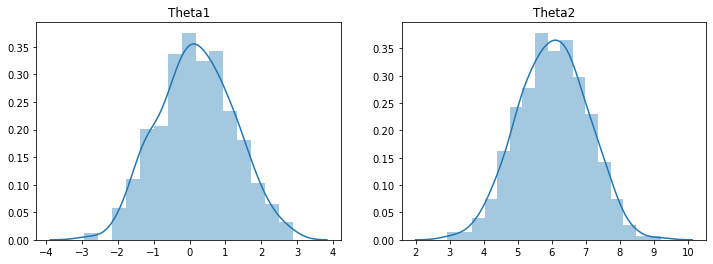

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(theta1, ax=axes[0])
sns.distplot(theta2, ax=axes[1])
axes[0].set_title("Theta1")
axes[1].set_title("Theta2")
plt.show()